In [1]:
# Adaptation of https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import dds
import sklearn
import pandas as pd
import logging
logging.basicConfig(level=logging.DEBUG)

import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json


In [2]:
%%sh
rm -rf /tmp/data/*
rm -rf /tmp/blobs/*
rm -rf /tmp/*.png

In [3]:
path_raw = "/wine-quality/raw"
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

def _load_data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


def data():
    return dds.keep(path_raw, _load_data)
# data = lambda: dds.keep(path_raw, _load_data)

In [4]:
data().head(3)

DEBUG:dds._api:_eval_new_ctx: local_vars: ['GridSearchCV', 'In', 'Out', 'RandomForestRegressor', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_ih', '_ii', '_iii', '_load_data', '_oh', 'data', 'dds', 'exit', 'get_ipython', 'io', 'json', 'logging', 'make_pipeline', 'mean_squared_error', 'np', 'path_model', 'path_model_stats', 'path_raw', 'pd', 'preprocessing', 'quit', 'r2_score', 'requests', 'sklearn', 'train_test_split']
DEBUG:dds.fun_args:get_arg_ctx: <function _load_data at 0x7ff7f2c168b0>: arg_sig=() args=()
DEBUG:dds._api:arg_ctx: FunctionArgContext(named_args=OrderedDict(), inner_call_key=None)
DEBUG:dds.introspect:_introspect: <function _load_data at 0x7ff7f2c168b0>: fun_path=<__main__._load_data> fun_module=<module '__main__'>
DEBUG:dds.introspect:Starting _introspect: <function _load_data at 0x7ff7f2c168b0>: src=def _load_data():
    print("*** in _load_data ***")
    ur

DEBUG:dds.introspect:is_authorized_path: {'__global__', '__main__', 'dds'} <pandas>
DEBUG:dds.introspect:visit_Name: pd: skipping (unauthorized)
DEBUG:dds.introspect:ExternalVarsVisitor:visit_Name: id: io local_dep_path:io
DEBUG:dds.introspect:is_authorized_path: {'__global__', '__main__', 'dds'} <io>
DEBUG:dds.introspect:visit_Name: io: skipping (unauthorized)
DEBUG:dds.introspect:ExternalVarsVisitor:visit_Name: id: x local_dep_path:x
DEBUG:dds.introspect:ExternalVarsVisitor:visit_Name: id: x skipping, in vars
DEBUG:dds.introspect:inspect_fun: ext_deps: []
DEBUG:dds.introspect:is_authorized_path: {'__global__', '__main__', 'dds'} <requests.api.get>
DEBUG:dds.introspect:is_authorized_path: {'__global__', '__main__', 'dds'} <pandas.io.parsers.read_csv>
DEBUG:dds.introspect:is_authorized_path: {'__global__', '__main__', 'dds'} <io.StringIO>
DEBUG:dds.introspect:Could not find x in <module '__main__'>, attempting a direct load
DEBUG:dds.introspect:Could not load name x, looking into the g

*** in _load_data ***


/home/ubuntu/miniconda/envs/dds/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nl-userproxy-access.net.abnamro.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
DEBUG:urllib3.connectionpool:https://raw.githubusercontent.com:443 "GET /zygmuntz/wine-quality/master/winequality/winequality-red.csv HTTP/1.1" 200 28445
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function _load_data at 0x7ff7f2c168b0>: completed
INFO:dds._api:_eval:Storing blob into key ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
INFO:dds.codec:Loading pandas codecs
DEBUG:dds.codecs.pandas:Committed dataframe to parquet: /tmp/dds/internal/blobs/ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
DEBUG:dds.store:Committed new blob in ccd1ea31245b11507b79fdf02946f9438d7de3b6933ac87348ed8cb94a7bc0d5
DEB

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [5]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred),
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


# dds.eval(pipeline, dds_export_graph="1.png")


In [6]:
%%sh
# cat /tmp/data/wine-quality/my_model_stats.json

In [7]:

@dds.dds_function("/p1")
def f1(): return 2

@dds.dds_function("/p2")
def f2(): return 2 + f1()

@dds.dds_function("/p3")
def f3(): return 1 + f1() + f2()

@dds.dds_function("/p4")
def f4(): return 1


def f():
    f4()
    f3()

dds.eval(f, dds_export_graph="/tmp/2.png", dds_extra_debug=True)

DEBUG:dds._api:_eval_new_ctx: local_vars: ['GridSearchCV', 'In', 'Out', 'RandomForestRegressor', '_', '_4', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_ih', '_ii', '_iii', '_load_data', '_oh', 'build_model', 'data', 'dds', 'exit', 'f', 'f1', 'f2', 'f3', 'f4', 'get_ipython', 'io', 'json', 'logging', 'make_pipeline', 'mean_squared_error', 'model_stats', 'np', 'path_model', 'path_model_stats', 'path_raw', 'pd', 'pipeline', 'preprocessing', 'quit', 'r2_score', 'requests', 'sklearn', 'train_test_split']
DEBUG:dds.fun_args:get_arg_ctx: <function f at 0x7ff831e6c0d0>: arg_sig=() args=()
DEBUG:dds._api:arg_ctx: FunctionArgContext(named_args=OrderedDict(), inner_call_key=None)
DEBUG:dds.introspect:_introspect: <function f at 0x7ff831e6c0d0>: fun_path=<__main__.f> fun_module=<module '__main__'>
DEBUG:dds.introspect:Starting _introspect: <function f at 0x7ff831e6c0d0>: s

DEBUG:dds.introspect:local vars: []
DEBUG:dds.introspect:inspect_fun: <__main__.f1> local_vars: set()
DEBUG:dds.introspect:inspect_fun: ext_deps: []
DEBUG:dds.introspect:_path_annotation: local_path: dds/dds_function
DEBUG:dds.introspect:_path_annotation: caller_fun_path: <dds._annotations.dds_function>
DEBUG:dds.introspect:inspect_fun: path from annotation: /p1
DEBUG:dds.introspect:_introspect: <function f2 at 0x7ff831e6c310>: fun_path=<__main__.f2> fun_module=<module '__main__'>
DEBUG:dds.introspect:Starting _introspect: <function f2 at 0x7ff831e6c310>: src=@dds.dds_function("/p2")
def f2(): return 2 + f1()

DEBUG:dds.introspect:_introspect ast_src:
 FunctionDef(
    lineno=2,
    col_offset=0,
    end_lineno=2,
    end_col_offset=25,
    name='f2',
    args=arguments(posonlyargs=[], args=[], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]),
    body=[
        Return(
            lineno=2,
            col_offset=10,
            end_lineno=2,
            end_col_of

INFO:dds.store:Link /tmp/dds/data/p3 -> /tmp/dds/internal/blobs/5641341715cabb45459f415453c5575420f9162b7498356c723386c1176b0e64
INFO:dds.store:Link /tmp/dds/data/p1 -> /tmp/dds/internal/blobs/5288fae92ef5eda3837a1a03c8b79ab72b8b1e4d6c55d11990988d0e115c0388
INFO:dds.store:Link /tmp/dds/data/p2 -> /tmp/dds/internal/blobs/28bf1959ff29e23039387bda66ae3794f93690a5073d652737361ce8501a2daf


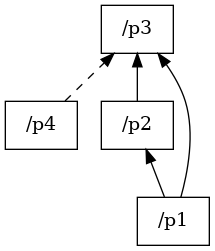

In [8]:
from IPython.display import Image
Image("/tmp/2.png")